In [37]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

%matplotlib inline

In [38]:
series = np.sin((0.1 * np.arange(400)) ** 2)

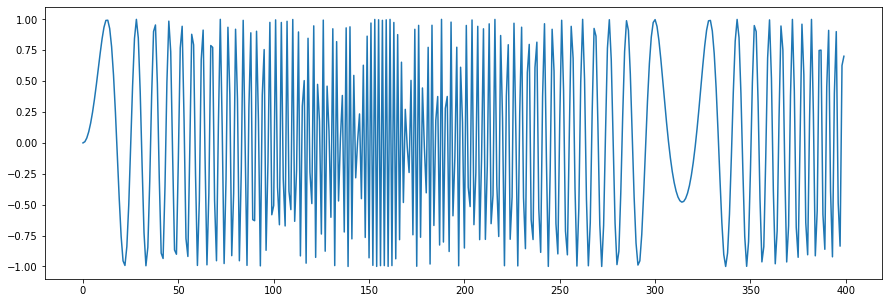

In [39]:
plt.figure(figsize=(15, 5))
plt.plot(series)
plt.show()

In [40]:
T = 10
D = 1
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t + T]
    X.append(x)
    y = series[t + T]
    Y.append(y)
X = np.array(X).reshape(-1, T, D)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print(f"X.shape = {X.shape}, Y.shape = {Y.shape}")

X.shape = (390, 10, 1), Y.shape = (390, 1)


In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [42]:
class RNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.rnn = nn.LSTM(input_size=self.D, 
                          hidden_size=self.M, 
                          num_layers=self.L, 
                          batch_first=True)
        self.fc = nn.Linear(in_features=self.M, 
                           out_features=self.K)
        
    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        
        out, _ = self.rnn(X, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [43]:
model = RNN(n_inputs=1, n_hidden=10, n_rnnlayers=1, n_outputs=1)
model.to(device)

RNN(
  (rnn): LSTM(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [44]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.05)

In [45]:
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [46]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [47]:
def full_gd(model, 
           criterion, 
           optimizer, 
           X_train, 
           y_train, 
           X_test, 
           y_test, 
           epochs=200):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        outputs = model(X_train)
        loss = criterion(outputs, y_train) 
        train_losses[epoch] = loss.item()
        
        loss.backward()
        optimizer.step()
        
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[epoch] = test_loss.item()
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")
    return train_losses, test_losses

In [48]:
train_losses, test_losses = full_gd(model, 
                                    criterion, 
                                    optimizer, 
                                    X_train, 
                                    y_train, 
                                    X_test, 
                                    y_test) 

Epoch 5/200, Train Loss: 0.5094, Test Loss: 0.5341
Epoch 10/200, Train Loss: 0.4966, Test Loss: 0.6668
Epoch 15/200, Train Loss: 0.4746, Test Loss: 0.5885
Epoch 20/200, Train Loss: 0.4154, Test Loss: 0.5352
Epoch 25/200, Train Loss: 0.3257, Test Loss: 0.4761
Epoch 30/200, Train Loss: 0.1840, Test Loss: 0.3212
Epoch 35/200, Train Loss: 0.0632, Test Loss: 0.1051
Epoch 40/200, Train Loss: 0.0371, Test Loss: 0.0618
Epoch 45/200, Train Loss: 0.0258, Test Loss: 0.0509
Epoch 50/200, Train Loss: 0.0164, Test Loss: 0.0536
Epoch 55/200, Train Loss: 0.0141, Test Loss: 0.0430
Epoch 60/200, Train Loss: 0.0095, Test Loss: 0.0355
Epoch 65/200, Train Loss: 0.0071, Test Loss: 0.0403
Epoch 70/200, Train Loss: 0.0051, Test Loss: 0.0436
Epoch 75/200, Train Loss: 0.0042, Test Loss: 0.0389
Epoch 80/200, Train Loss: 0.0035, Test Loss: 0.0471
Epoch 85/200, Train Loss: 0.0031, Test Loss: 0.0456
Epoch 90/200, Train Loss: 0.0028, Test Loss: 0.0546
Epoch 95/200, Train Loss: 0.0025, Test Loss: 0.0558
Epoch 100/200

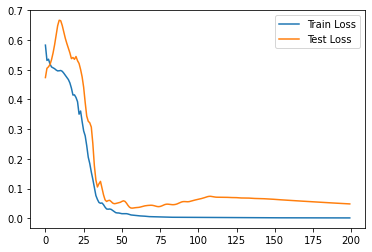

In [49]:
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.show()

In [50]:
validation_target = Y[-N//2:]
validation_predictions = []

i = 0

while len(validation_predictions) < len(validation_target):
    input_ = X_test[i].reshape(-1, T, 1)
    p = model(input_)[0, 0].item()
    i += 1
    
    validation_predictions.append(p)

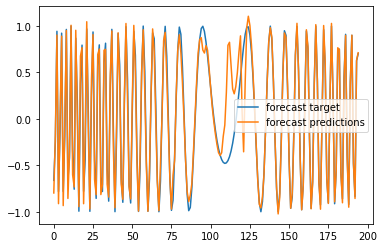

In [51]:
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast predictions")
plt.legend()
plt.show()

In [52]:
validation_target = Y[-N//2:]
validation_predictions = []

last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1, T, 1)
    p = model(input_)
    
    validation_predictions.append(p[0, 0].item())
    
    last_x = torch.cat((last_x[1:], p[0]))

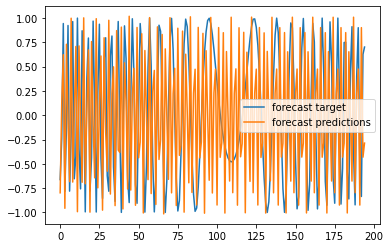

In [53]:
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast predictions")
plt.legend()
plt.show()